In [624]:
#!/usr/bin/python
# updated DBR 02/2025 #

%matplotlib inline  

import os

import numpy as np
import matplotlib.pyplot as plt

import matplotlib
matplotlib.rcParams['font.family'] = 'Myriad Pro'  # Choose the desired font family (e.g., 'serif', 'sans-serif', 'monospace')
matplotlib.rcParams['font.size'] = 10  # Choose the desired font size

import matplotlib.colors as mcolors
import matplotlib.cm as cm
import pandas as pd
import time
import scipy.stats as st

#ipython magic to make module autoreload
%load_ext autoreload
%autoreload 2

import seaborn as sns
sns.set_style("ticks")

#pull in the code to do the sims!
import ra_module
import clonesim_module as clmod

import scipy.optimize as opt #for power law fitting

import resource
resource.setrlimit(resource.RLIMIT_NOFILE, (1000,-1)) #allow many plots

import pickle

colormap=cm.jet

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [683]:
#read in data
dfM_data=pd.read_csv('data_metrics.csv') #computed in prior sheet

#read in pickle dataframes

sim_name = 'parallel_full2'
#sim_name = 'parallel_Tmp'

with open('models-'+sim_name+'.pkl', 'rb') as f:
    modeld = pickle.load(f)
with open('model_change-'+sim_name+'.pkl', 'rb') as f:
    mcdf = pickle.load(f)
with open('model_change_num-'+sim_name+'.pkl', 'rb') as f:
    mcdf_num = pickle.load(f)

#    #metrics = al_TCR+al_H+[d0T,d1T,d2T,d0H,d1H,d2H]+[fit_lame,fit_lamc,thI,thD,rho]

#read in full score list
dfM=pd.read_csv('model_scores-'+sim_name+'.csv')#,usecols=[1,2,3,4,5,12,13,14,15,16])

dfM.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,15,16,17,18,19,20,21,22,23,24
0,0,0.173728,0.249349,0.410912,1.313793,1.451034,-0.811442,-0.583626,-0.000619,0.001237,...,0.730140,0.6663,0.582756,0.496672,0.6663,0.582756,0.496672,0.6663,0.582756,0.496672
1,1,0.165511,0.251523,0.405154,1.313793,1.451034,-0.793121,-0.599860,-0.003196,-0.001156,...,0.728332,0.6707,0.588527,0.501756,0.6707,0.588527,0.501756,0.6707,0.588527,0.501756
2,2,0.172657,0.246688,0.407149,1.245172,1.313793,-0.611163,-0.434704,0.000918,0.000149,...,0.730674,0.6679,0.586457,0.503170,0.6679,0.586457,0.503170,0.6679,0.586457,0.503170
3,3,0.174223,0.242704,0.411290,1.245172,1.313793,-0.601952,-0.340095,0.003416,0.000818,...,0.736811,0.6607,0.578675,0.495540,0.6607,0.578675,0.495540,0.6607,0.578675,0.495540
4,4,0.175377,0.251363,0.407385,1.313793,1.382414,-0.772786,-0.383110,0.002355,-0.002157,...,0.726322,0.6671,0.585540,0.501958,0.6671,0.585540,0.501958,0.6671,0.585540,0.501958


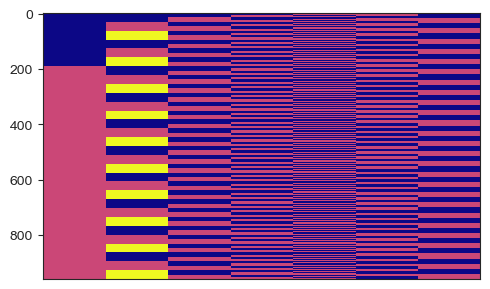

In [741]:
#original set of models

fig, ax = plt.subplots(figsize=(5, 3))  # Width 12, Height 5

# Display the matrix as an image
ax.matshow(mcdf_num, cmap='plasma')

# Force square cells (important for keeping proportions)
ax.set_aspect("auto")  # Change to 'auto' if stretching is needed

ax.set_xticks([])#np.arange(len(mcdf_num.columns)))
#ax.set_xticklabels(mcdf_num.columns)

plt.tight_layout()
plt.savefig('figures/model-fulltest.svg')


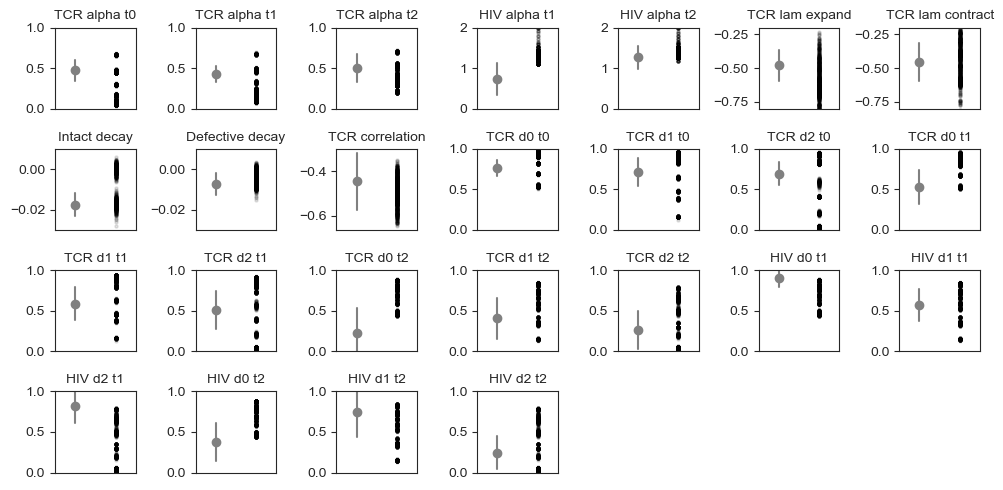

In [685]:
plt.figure(figsize=(10,5))

for i in range(1,len(dfM_data)):
    tdf=dfM_data.iloc[i,:]
    
    plt.subplot(4,7,i)
    plt.scatter(1,tdf['data_mean'],c='gray')
    plt.plot([1,1],[tdf['data_mean']-tdf['data_std'],tdf['data_mean']+tdf['data_std']],color='gray')
   
    plt.scatter(1+np.ones(len(dfM)),dfM.iloc[:,i].values,alpha=0.1,s=5,color='k')
    plt.title(tdf['name'],fontsize=10)
    plt.xlim([0.5,2.5])
    
    if i in [1,2,3,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26]:
        plt.ylim([0,1])
    if i in [4,5]:
        plt.ylim([0,2])
    if i in [6,7]:
        plt.ylim([-0.8,-0.2])
    if i in [8,9]:
        plt.ylim([-0.03,0.01])
        
    plt.xticks([])
plt.tight_layout()
plt.savefig('figures/model-allmetrics.svg')


In [686]:
len(dfM_data)

26

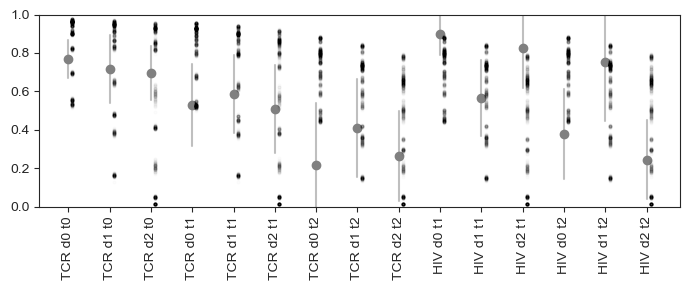

In [689]:
plt.figure(figsize=(7,3))

xl=[]
for j,i in enumerate([11,12,13,14,15,16,17,18,19,20,21,22,23,24,25]):
    tdf=dfM_data.iloc[i,:]
    
    plt.scatter(j,tdf['data_mean'],c='gray')
    plt.plot([j,j],[tdf['data_mean']-tdf['data_std'],tdf['data_mean']+tdf['data_std']],color='gray',alpha=0.5)
   
    plt.scatter(j+np.zeros(len(dfM))+0.1,dfM.iloc[:,i].values,alpha=0.01,s=5,color='k')

    xl.append(tdf['name'])
    plt.ylim([0,1])
        
plt.xticks(np.arange(len(xl)),xl,rotation=90)
plt.tight_layout()
plt.savefig('figures/model-allmetrics-ecology.svg')


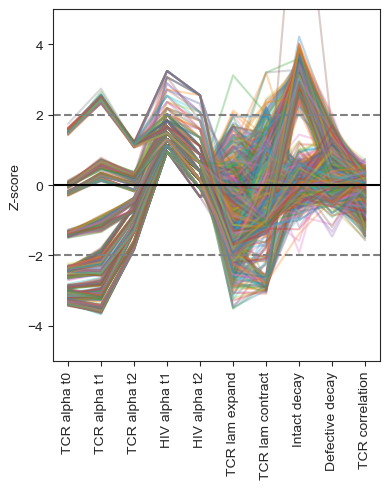

In [724]:
#calculate z scores

Zl = []
plt.figure(figsize=(4,5))
#for i in range(11):
for i in range(len(dfM)):
    
    Z = (dfM.iloc[i,1:11].values-dfM_data['data_mean'].iloc[1:11])/dfM_data['data_std'].iloc[1:11]
    
    Z = Z.fillna(10)
    
    plt.plot(np.arange(len(Z)),Z,alpha=0.3)
    
    #if (Z<2).all():
    Zl.append(np.sum(Z**2))
    
plt.xticks(np.arange(10),dfM_data['name'].iloc[1:11],rotation=90)
#plt.xticks(np.arange(len(dfM_data['name'])-1),dfM_data['name'].iloc[1:],rotation=90)
plt.axhline(0,ls='-',color='k')
plt.axhline(-2,ls='--',color='gray')
plt.axhline(2,ls='--',color='gray')
plt.ylim([-5,5])
plt.ylabel('Z-score')
plt.tight_layout()
plt.savefig('figures/model-Zscore-all.svg')


In [725]:
#add in Z score

mcdf['Z^2']=Zl


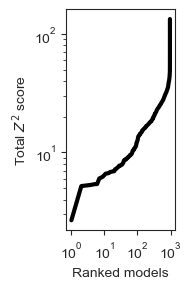

In [746]:
#plot total

plt.figure(figsize=(2,3))
plt.plot(np.arange(len(Zl))+1,np.sort(Zl),color='k',lw=3)
#plt.axvline(20,color='gray')
plt.ylabel(r'Total $Z^2$ score')
plt.xlabel('Ranked models')
#plt.semilogy()
plt.loglog()
plt.xticks([1,10,100,1000])
plt.tight_layout()
plt.savefig('figures/model-Z2score-rank.svg')


In [713]:
#sorted version

mcdf_sort = mcdf.sort_values(by='Z^2')

In [714]:
sZ = mcdf_sort.index.values

top10 = sZ[:9] #indices of best model


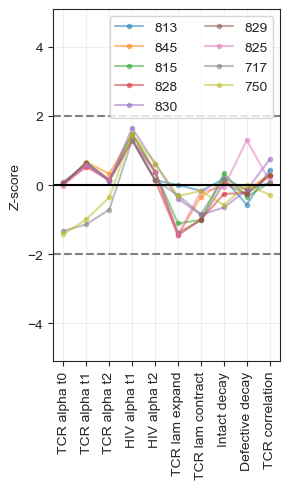

In [723]:
#look at scores from top 10

plt.figure(figsize=(3,5))

for i in top10:
    
    Z = (dfM.iloc[i,1:11].values-dfM_data['data_mean'].iloc[1:11])/dfM_data['data_std'].iloc[1:11]
    
    Z = Z.fillna(10)
    
    plt.plot(np.arange(len(Z)),Z,alpha=0.5,label=i,marker='.')
    
plt.xticks(np.arange(10),dfM_data['name'].iloc[1:11],rotation=90)
#plt.xticks(np.arange(len(dfM_data['name'].iloc[1:])),dfM_data['name'].iloc[1:],rotation=90)
plt.axhline(0,ls='-',color='k')
plt.axhline(-2,ls='--',color='gray')
plt.axhline(2,ls='--',color='gray')
plt.grid('on',alpha=0.3)
plt.ylim([-5.1,5.1])
plt.ylabel('Z-score')
plt.legend(ncol=2)
plt.tight_layout()
plt.savefig('figures/model-Zscore-top10.svg')


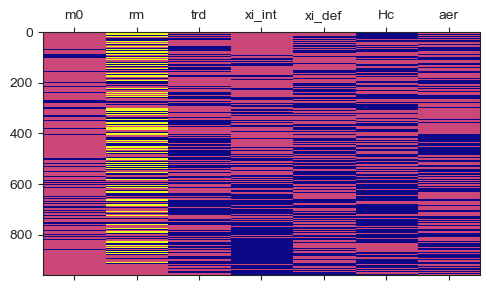

In [733]:
#show matrix in order

#original set of models

fig, ax = plt.subplots(figsize=(5, 3))  # Width 12, Height 5

# Display the matrix as an image
ax.matshow(mcdf_num.iloc[sZ], cmap='plasma')

# Force square cells (important for keeping proportions)
ax.set_aspect("auto")  # Change to 'auto' if stretching is needed

ax.set_xticks(np.arange(len(mcdf_num.columns)))
ax.set_xticklabels(mcdf_num.columns)

plt.tight_layout()
plt.savefig('figures/model-all-sorted.svg')



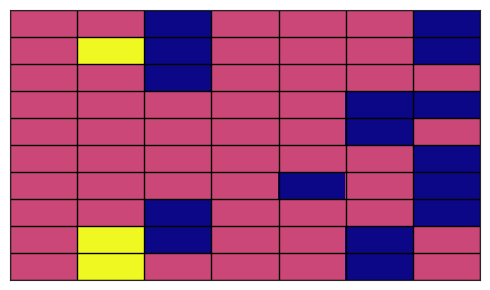

In [747]:
#show matrix in order

#original set of models

fig, ax = plt.subplots(figsize=(5, 3))  # Width 12, Height 5

# Display the matrix as an image
ax.imshow(mcdf_num.iloc[sZ], cmap='plasma')

# Force square cells (important for keeping proportions)
ax.set_aspect("auto")  # Change to 'auto' if stretching is needed

#ax.set_xticks(np.arange(len(mcdf_num.columns)))
#ax.set_xticklabels(mcdf_num.columns)

# Fix grid alignment by setting ticks at integer positions
#ax.set_xticks(np.arange(matrix.shape[1]), minor=False)
#ax.set_yticks(np.arange(matrix.shape[0]), minor=False)

# Set grid lines at the correct positions
ax.set_xticks(np.arange(-0.5, mcdf_num.shape[1], 1), minor=True)
ax.set_yticks(np.arange(-0.5, mcdf_num.shape[0], 1), minor=True)
ax.grid(which="minor", color="black", linestyle='-', linewidth=1)

# Hide major ticks
ax.tick_params(which="both", bottom=False, left=False, labelbottom=False, labelleft=False)

#plt.grid('on')
plt.ylim([9.5,-0.5,])
#plt.yticks(np.arange(10,0))
plt.tight_layout()
plt.savefig('figures/model-all-sorted-top10.svg')



In [748]:
mcdf.iloc[sZ[:10]]

,m0,Tmp,rm,trd,xi_int,xi_def,Hc,aer,Z^2
813,pwl,0.9,uni,20000,0.000578,0.000231,0.1,1,2.679950
845,pwl,0.9,exp,20000,0.000578,0.000231,0.1,1,5.206696
815,pwl,0.9,uni,20000,0.000578,0.000231,0.1,0,5.273911
828,pwl,0.9,uni,50,0.000578,0.000231,0.0,1,5.330786
830,pwl,0.9,uni,50,0.000578,0.000231,0.0,0,5.404515
829,pwl,0.9,uni,50,0.000578,0.000231,0.1,1,5.413890
825,pwl,0.9,uni,50,0.000578,0.000000,0.1,1,6.039978
717,pwl,0.8,uni,20000,0.000578,0.000231,0.1,1,6.144259
750,pwl,0.8,exp,20000,0.000578,0.000231,0.0,0,6.262869
862,pwl,0.9,exp,50,0.000578,0.000231,0.0,0,6.455205
